In [1]:
compare = "Total_mass" # file name (in the folder "data/model_comparison") of the comparison to be made
consider_models = "all" # list of int (from 0 to number of models - 1) or "all"
exclude_models = [4,5] # list of int (from 0 to number of models - 1)

Comparing models:
 - 0: ./archives/2023-03-29_46185e4/21/model_details.json
      Keys: loss, Max_Temperature_loss, Total_Mass_loss, Max_Temperature_MAE, Total_Mass_MAE, val_loss, val_Max_Temperature_loss, val_Total_Mass_loss, val_Max_Temperature_MAE, val_Total_Mass_MAE
 - 1: ./archives/2023-03-29_46185e4/24/model_details.json
      Keys: loss, Max_Temperature_loss, Total_Mass_loss, Max_Temperature_MAE, Total_Mass_MAE, val_loss, val_Max_Temperature_loss, val_Total_Mass_loss, val_Max_Temperature_MAE, val_Total_Mass_MAE
 - 2: ./archives/2023-03-29_46185e4/25/model_details.json
      Keys: loss, Max_temperature_loss, Total_mass_loss, Max_temperature_MAE, Total_mass_MAE, val_loss, val_Max_temperature_loss, val_Total_mass_loss, val_Max_temperature_MAE, val_Total_mass_MAE
 - 3: ./archives/2023-03-30_16812d1/3/model_details.json
      Keys: loss, Max_temperature_loss, Total_mass_loss, Max_temperature_MAE, Total_mass_MAE, val_loss, val_Max_temperature_loss, val_Total_mass_loss, val_Max_tempera

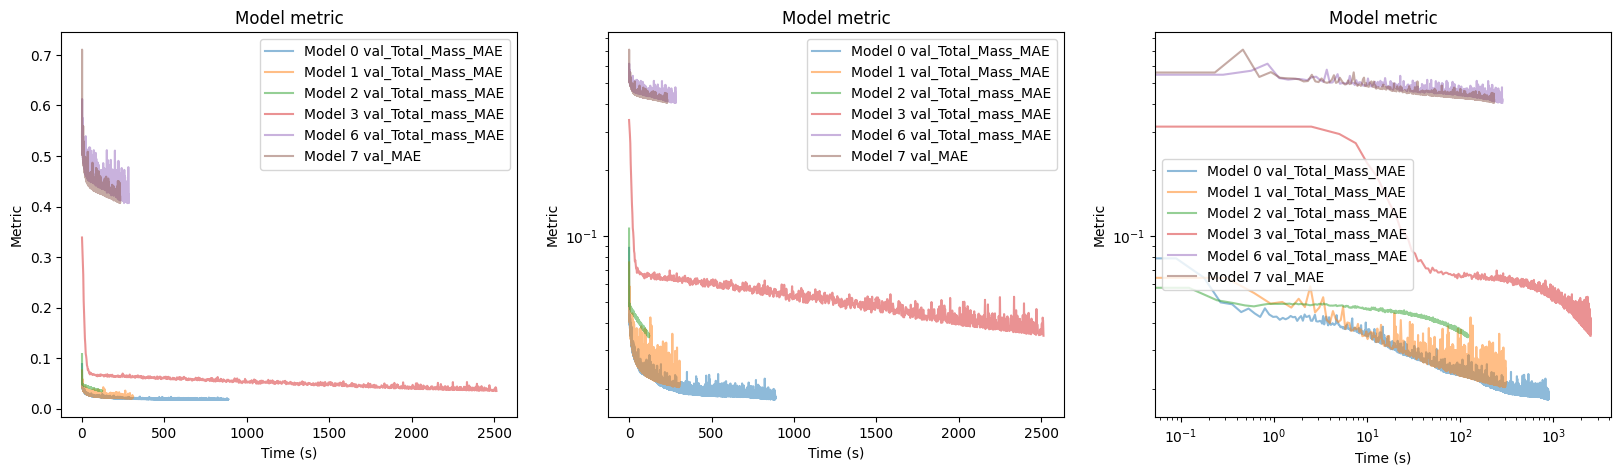

In [2]:
# Plot the comparison

import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
import pandas as pd
from scipy.signal import savgol_filter
import yaml
from IPython.display import *
import ipywidgets as widgets
from ipywidgets import *
from IPython.display import Image

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

source = f"data/model_comparison/{compare}.yml"

with open(source) as f:
    archives = yaml.safe_load(f)

print("Comparing models:")
for model_number, archive in enumerate(archives):

    if consider_models != "all" and model_number not in consider_models or model_number in exclude_models:
        continue

    with open(f'{archive}/history.pickle', "rb") as file_pi:
        history = pickle.load(file_pi)
    
    with open(f'{archive}/model_details.json') as file:
        details = json.load(file)

    epochs = details['epochs']
    training_time = details['training_time']
    summary = details['summary']
    score = details['score']
    metrics = details['metrics']

    time_range = np.linspace(0, training_time, epochs, endpoint=True)

    print(f" - {model_number}: {archive}/model_details.json\n      Keys: {', '.join(list(history.keys()))}")

    for key in history.keys():
        if (key.startswith('val_')) and (not key.endswith('_loss')):
            if (compare.startswith("detailed/")) or (compare.lower() in key.lower()) or key=="val_MAE":
                for ax in axs:
                    curve = history[key] # savgol_filter(history[key], 11, 1)
                    ax.plot(time_range, curve, alpha=0.5, label=f"Model {model_number} {key.replace(' ', '')}")

for ax in axs:
    ax.set_title(f'Model metric')
    ax.set_ylabel('Metric')
    ax.set_xlabel('Time (s)')
    ax.legend()

axs[1].set_yscale('log')
axs[2].set_xscale('log')
axs[2].set_yscale('log')

plt.show()

In [3]:
# Read model details

def print_model_details(id):

    if id >= len(archives):
        print(f"ID must be included in [0, {len(archives)-1}]")
        return

    with open(f'{archives[id]}/model_details.json') as file:
        details = json.load(file)
        
    if os.path.isfile(f'{archives[id]}/model.png'):
        Image(filename=f'{archives[id]}/model.png')
        print("\n".join(details['summary'][-5:]))
    else:
        if isinstance(details['summary'], str):
            print(details['summary'])
        else:
            print("\n".join(details['summary']))
    print("")
    print("Optimizer:", details['optimizer'])
    if isinstance(details['loss'], list):
        print("Loss:\n -", "\n - ".join(details['loss']))
    else:
        print("Loss:", details['loss'])
    print("Metrics:\n -", "\n - ".join(details['metrics']))
    print("")
    print("Epochs:", details['epochs'])
    print("Batch size:", details['batch_size'])
    print("")
    print(f"Training time: {int(details['training_time']//60)}m {details['training_time']%60:.2f}s" )
    print("Score:\n -", "\n - ".join([f"{i:.2e}" for i in details['score']]))
    print("")
    print("Dataset size:", details['dataset_size'])
    print("Validation fraction:", int(details['valid_frac'] * 100), "%")
    print("Test fraction:", int(details['test_frac'] * 100), "%")
    print("")
    print("Path:", archives[id])
    print("")
    if "inputs" in details:
        print("Inputs:\n -", "\n - ".join(details['inputs']))
    if "outputs" in details:
        print("Outputs:\n -", "\n - ".join(details['outputs']))


x_widget = Dropdown(options = [i for i in range(len(archives))], value = 0, description = "Model ID: ")

# Define a function that updates the content of y based on what we select for x
def update(*args):
    clear_output()
    display(x_widget)
    print_model_details(x_widget.value)

x_widget.observe(update)
update()

Dropdown(description='Model ID: ', options=(0, 1, 2, 3, 4, 5, 6, 7), value=0)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Dust Map (InputLayer)          [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 flatten (Flatten)              (None, 4096)         0           ['Dust Map[0][0]']               
                                                                                                  
 dense_1 (Dense)                (None, 32)           131104      ['flatten[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 32)           131104      ['flatten[0][0]']                
                                                                                              